# Short tau exercise: Part 1

Learning objectives:
* __the reconstruction of hadronic tau decays in different decay modes__ (this part)
* discrimination of hadronic tau decays against jets, electrons, and muons. (part 2)

Additional material:
* __TAU-16-003: Latest paper about tau reconstruction http://cms-results.web.cern.ch/cms-results/public-results/publications/TAU-16-003/index.html__
* DeepTau: Algorithm based on neural networks to discriminate taus against jets, muons, and electrons https://cds.cern.ch/record/2694158

In [1]:
import ROOT
from dm_migration import dm_migration

Welcome to JupyROOT 6.20/06


The ROOT files used below are created from simulated events in the CMS detector. They contain generated hadronic tau decays or other generated particles and information about spatially matched reconstructed hadronic tau decays. This matching allows us to use the content to study the efficiency of the tau reconstruction.

* The files were preprocessed using the tau validation tools here https://github.com/cms-tau-pog/TauReleaseValidation
* We extract the contained TTree "per_tau" that contains one entry per generated tau. The branches for reconstructed taus are only filled with values different from `-999` if a reconstructed hadronic tau was found. This way of storing the information allows us to study which fraction of taus was successfully reconstructed.
* Reconstructed taus have `pt > 18 GeV` and `|eta| < 2.3`
* Generated taus have `pt > 10 GeV` and `|eta| < 2.3`

Given that our reconstruction targets hadronic taus with `pt > 20 GeV`, we usually restrict to this range. 

*Note: Many analyses actually apply tighter cuts, e.g. `pt > 30 GeV`, and it will be interesting to check at each stage in this notebook how things change when increasing the pT cut even if you're not explicitly asked to do so* 

In [5]:
base_dir = '/Users/jan/cernbox/public/TauExercise'
tau_sample = f'{base_dir}/dy_nanoaod_v6_gen_tuple.root'
tau_file = ROOT.TFile.Open(tau_sample)
tau_tree = tau_file.Get('tree')

In this notebook, one can investigate which variables are contained in the tree and how they are distributed. One can also investigate this by other means such as with a TBrowser.

*If you feel adventurous, it can be an interesting exercise to use the first few lines of code below to write a general tool that makes plots of all variables in a TTree, making some assumptions about what "undefined" means and cutting out this part of the plot*

In [12]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false
}

<IPython.core.display.Javascript object>

['run', 'lumi', 'event', 'nvtx', 'ngvtx', 'rho', 'gpud', 'npu', 'ntrueint', 'pud', 'eoot', 'loot', 'tau_pt', 'tau_eta', 'tau_phi', 'tau_mass', 'tau_dxy', 'tau_dz', 'tau_charge', 'tau_decayMode', 'tau_chargedIso', 'tau_leadTkDeltaEta', 'tau_leadTkDeltaPhi', 'tau_leadTkPtOverTauPt', 'tau_neutralIso', 'tau_photonsOutsideSignalCone', 'tau_puCorr', 'tau_rawAntiEle', 'tau_rawIso', 'tau_rawMVAnewDM2017v2', 'tau_rawAntiEleCat', 'tau_idAntiEle', 'tau_idAntiMu', 'tau_idMVAnewDM2017v2', 'tau_genPartIdx', 'tau_genPartFlav', 'tau_rawDeepTau2017v2p1VSjet', 'tau_rawDeepTau2017v2p1VSmu', 'tau_rawDeepTau2017v2p1VSe', 'tau_idDeepTau2017v2p1VSjet', 'tau_idDeepTau2017v2p1VSmu', 'tau_idDeepTau2017v2p1VSe', 'tau_idDecayMode', 'tau_idDecayModeNewDMs', 'tau_gen_pt', 'tau_gen_eta', 'tau_gen_phi', 'tau_gen_mass', 'tau_gen_charge', 'tau_gen_decayMode', 'tau_jet_pt', 'tau_jet_eta', 'tau_jet_phi', 'tau_jet_mass']
run
lumi
event
nvtx
ngvtx
rho
gpud
npu
ntrueint
pud
eoot
loot
tau_pt
tau_eta
tau_phi
tau_mass
tau_dxy


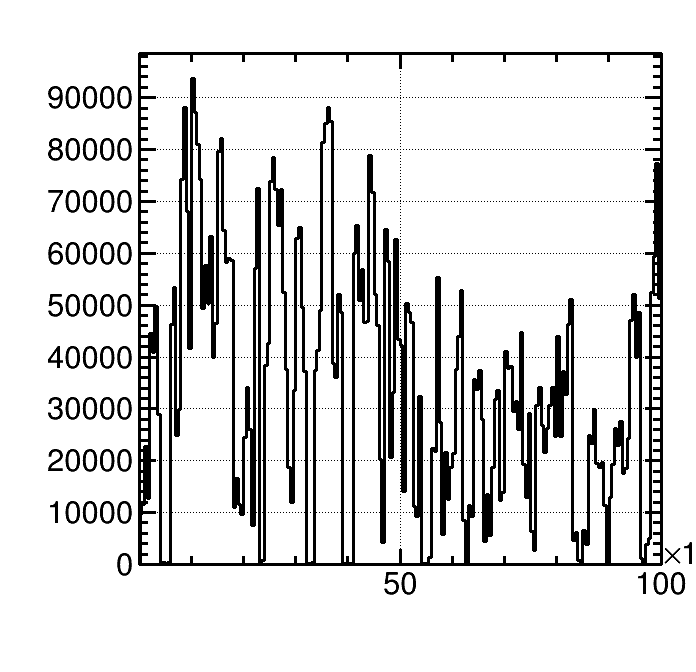

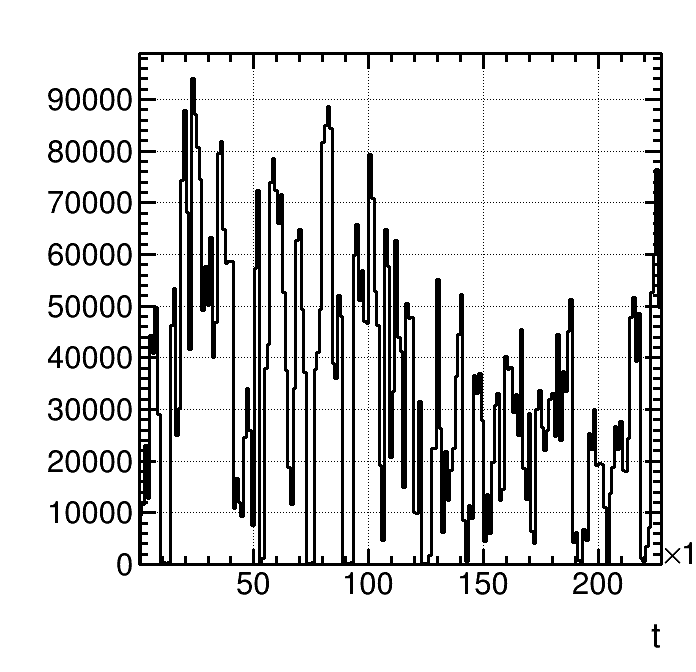

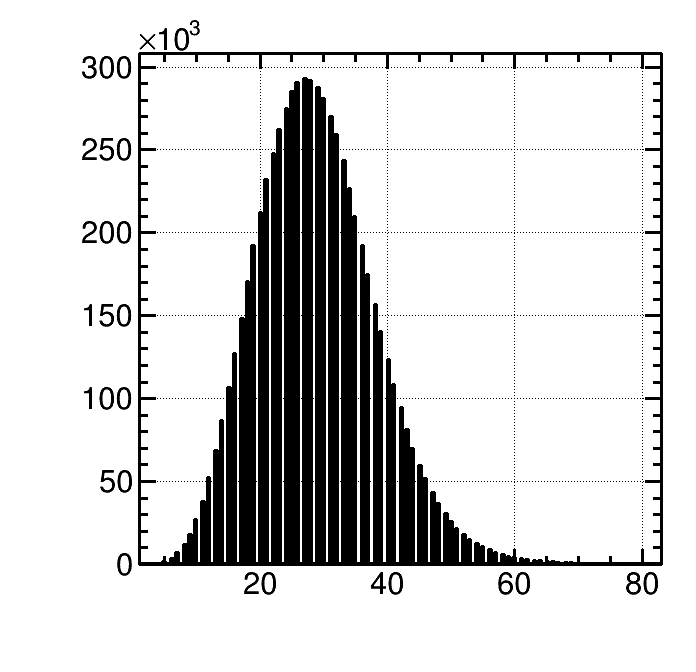

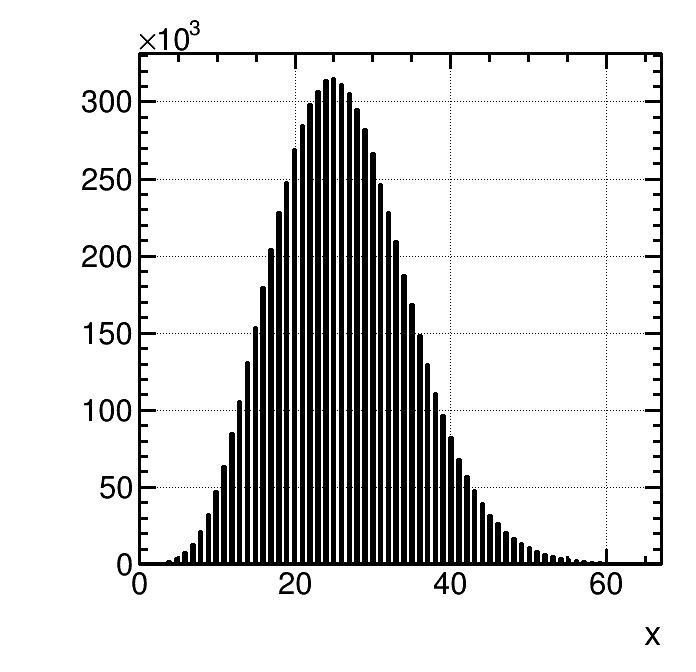

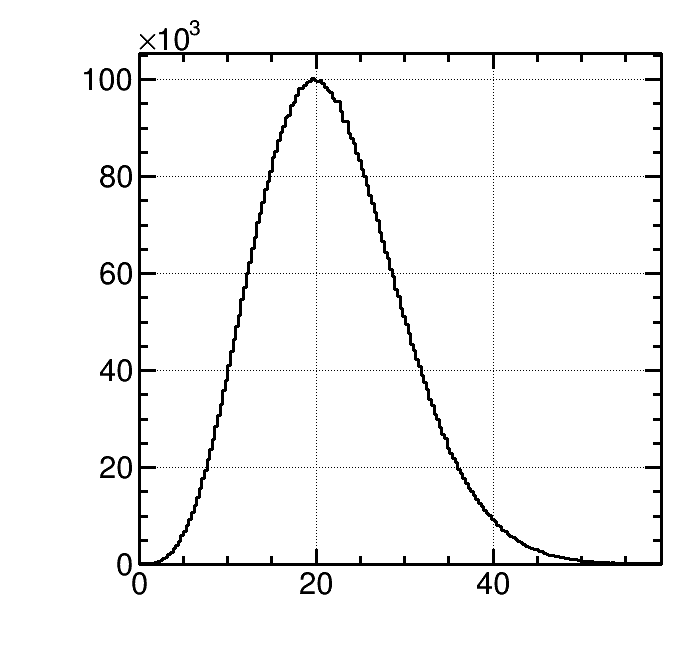

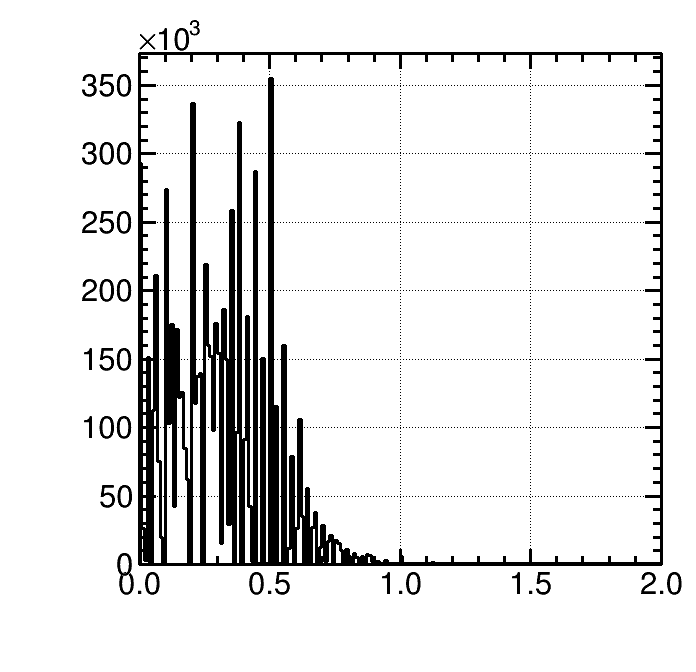

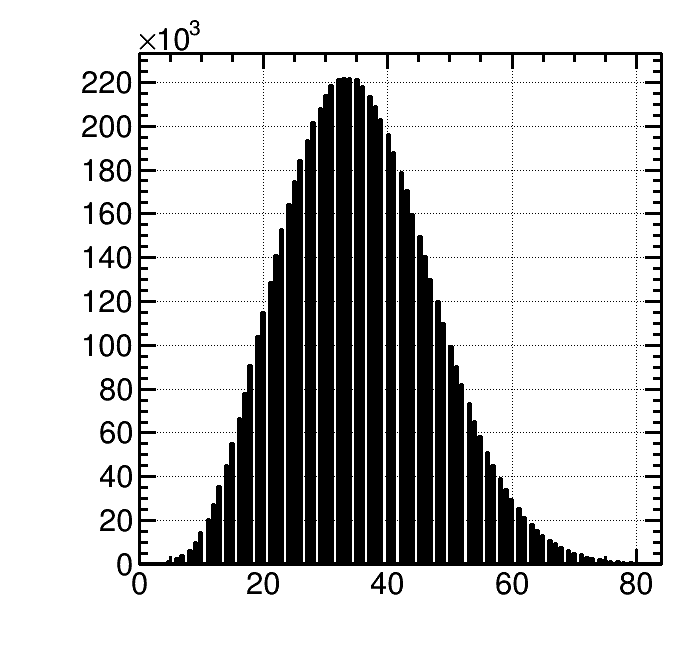

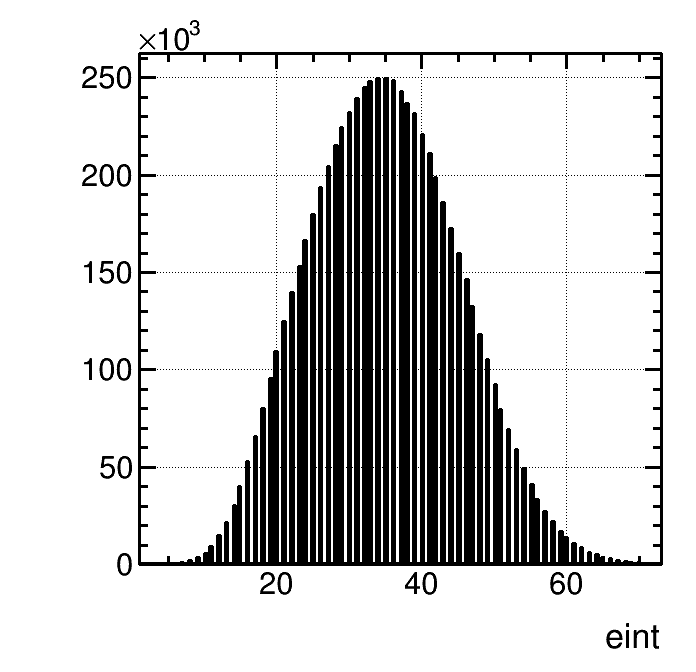

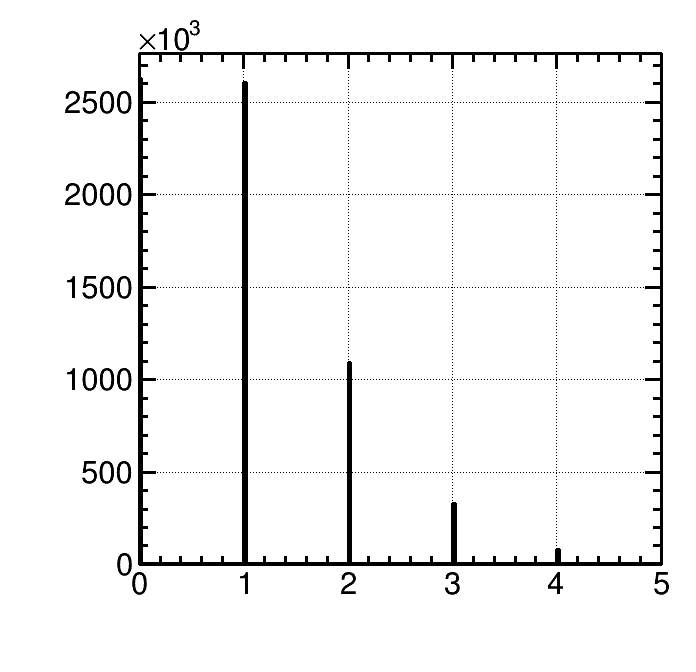

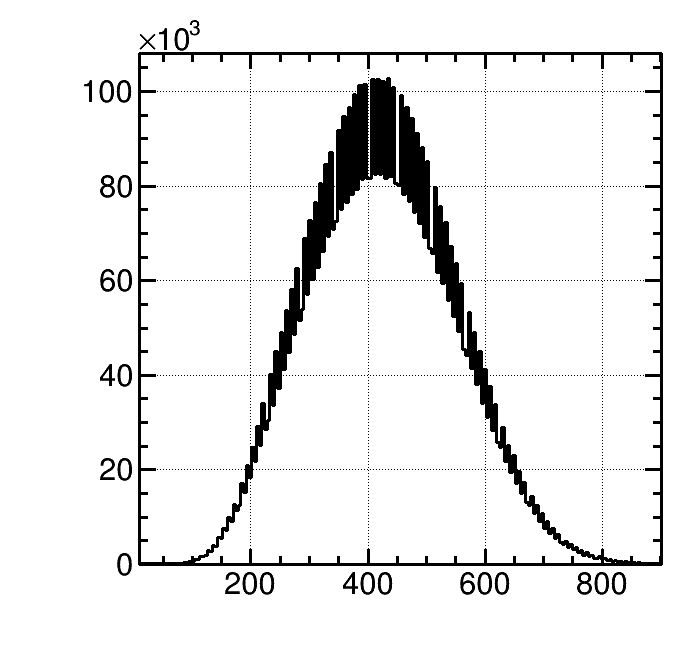

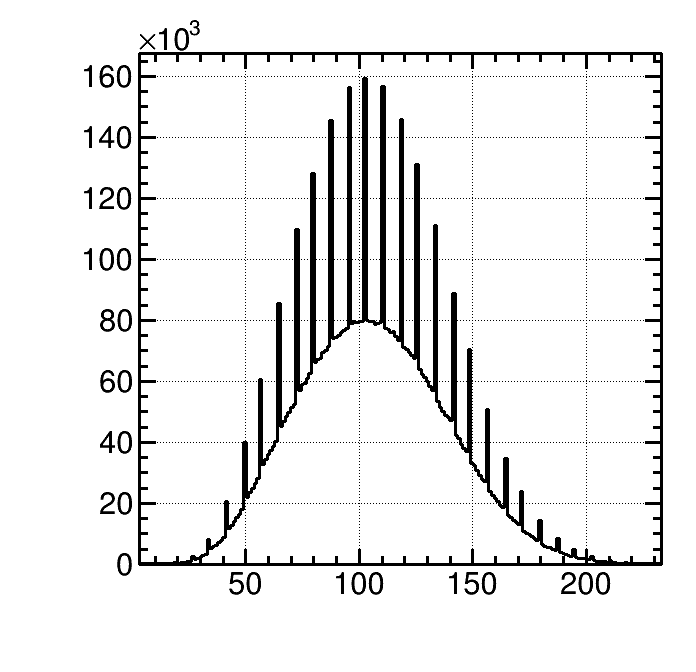

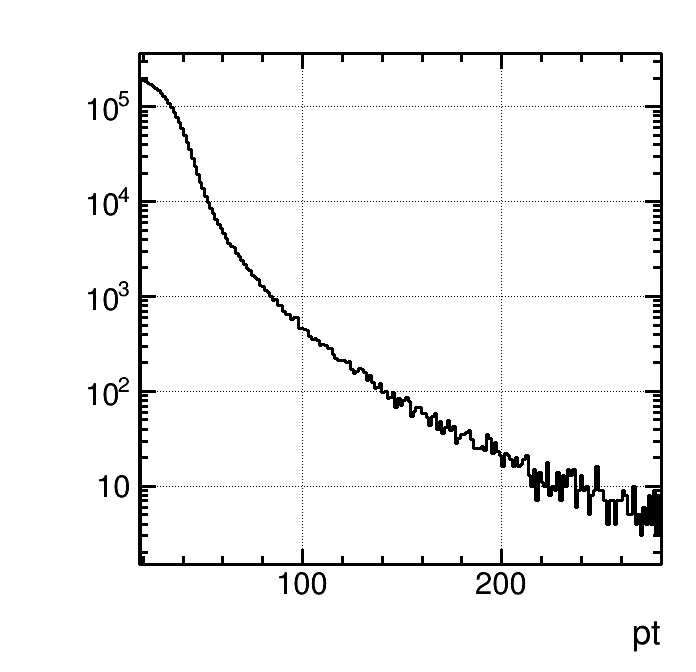

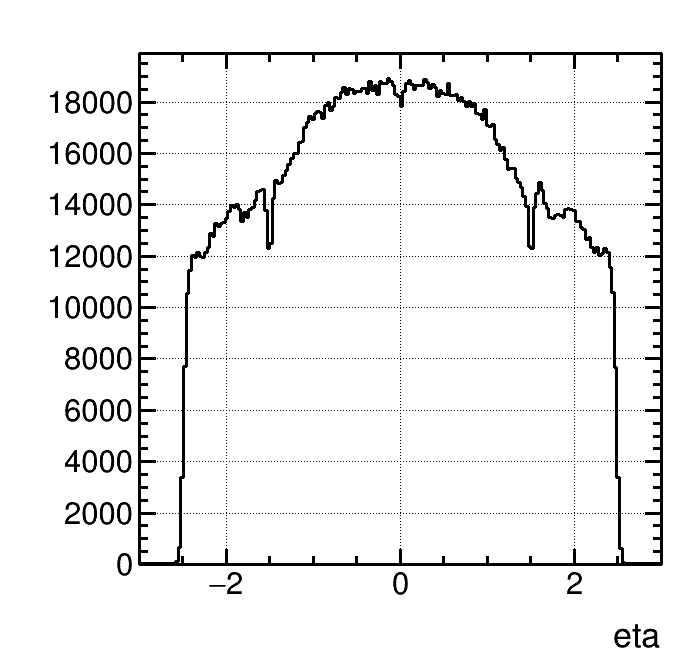

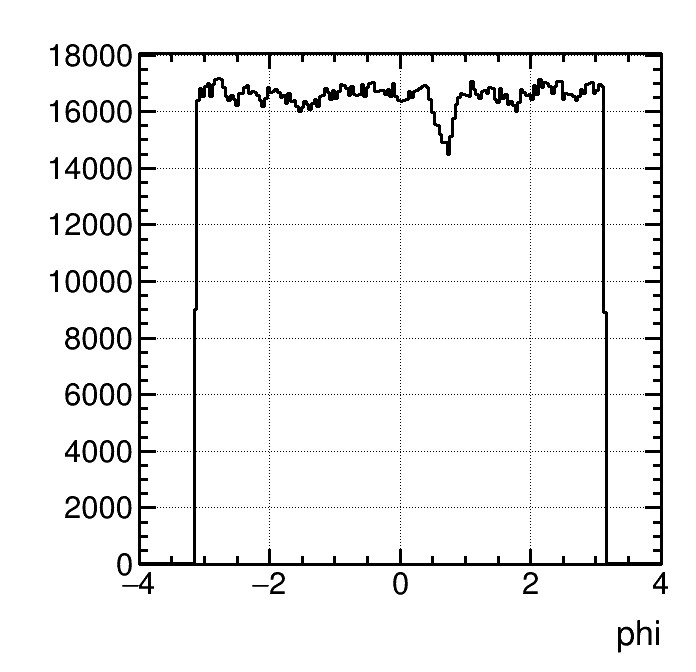

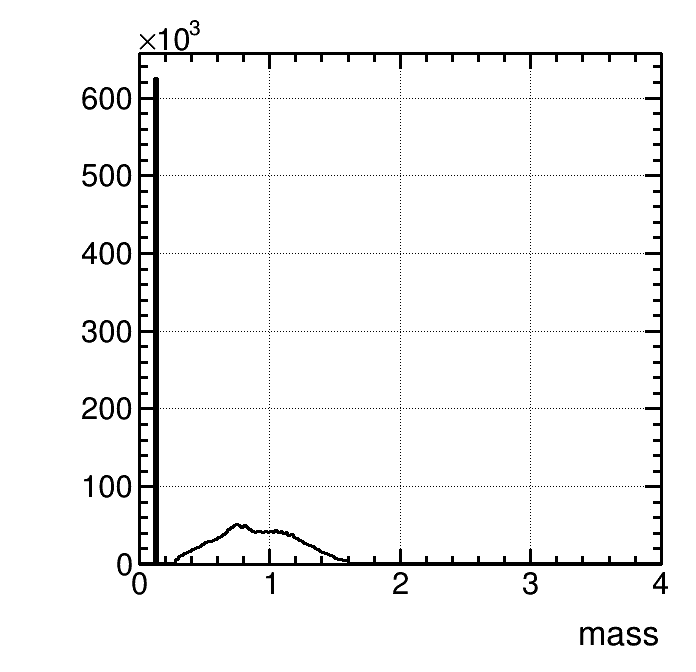

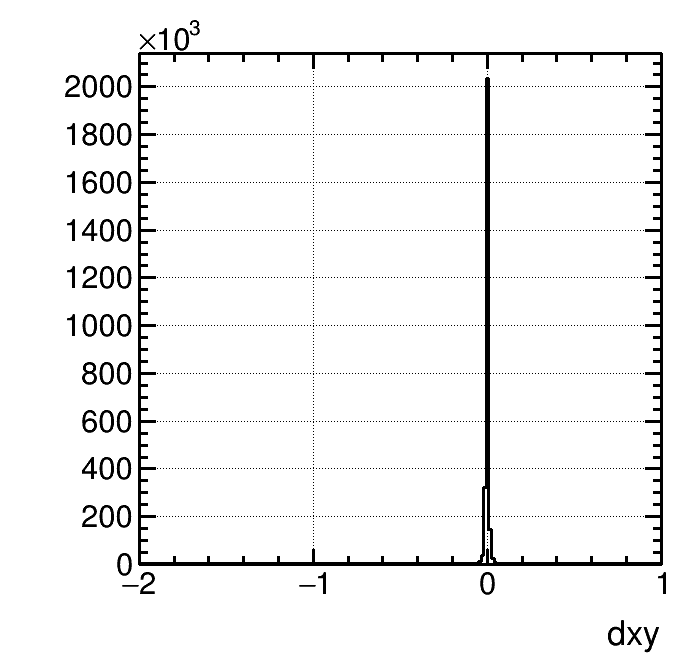

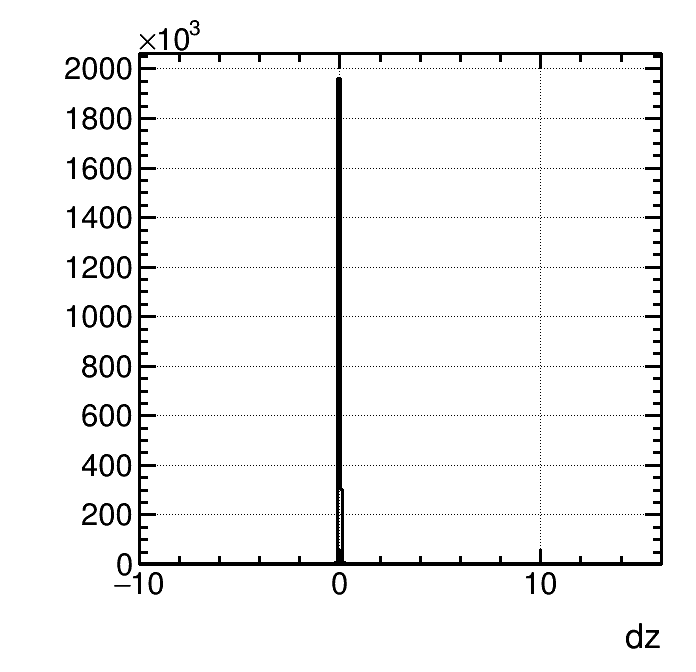

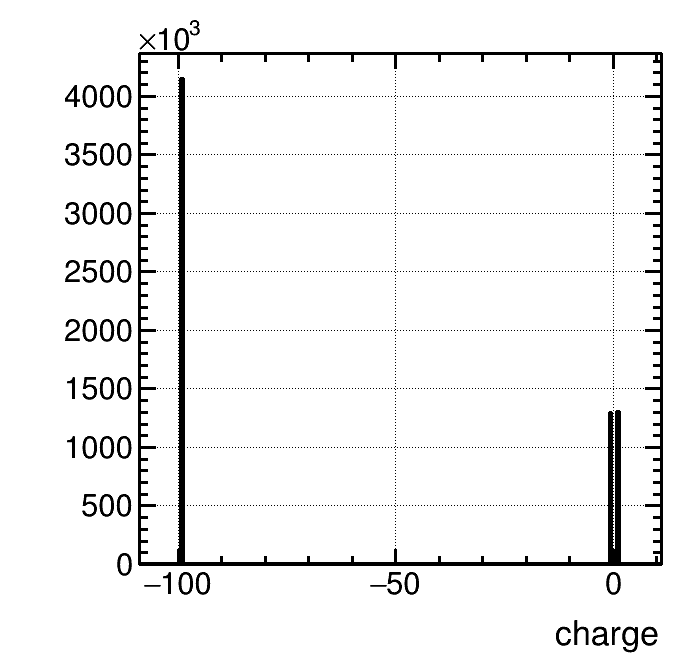

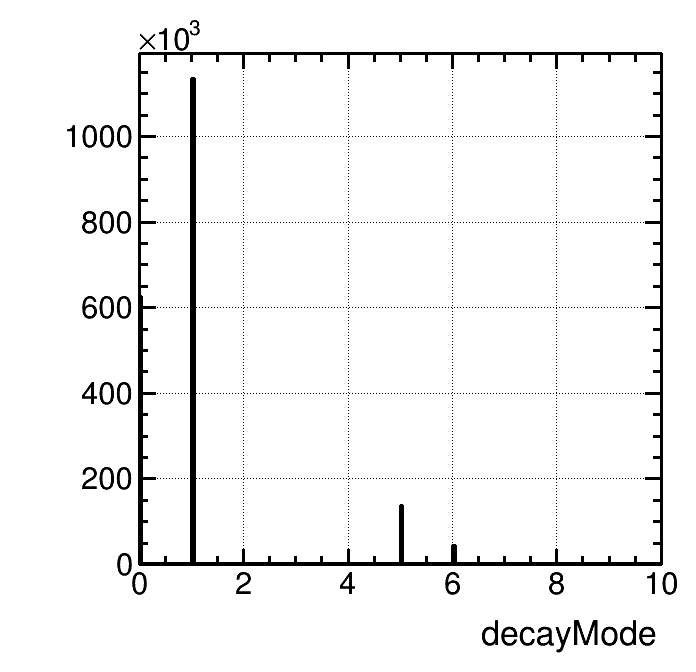

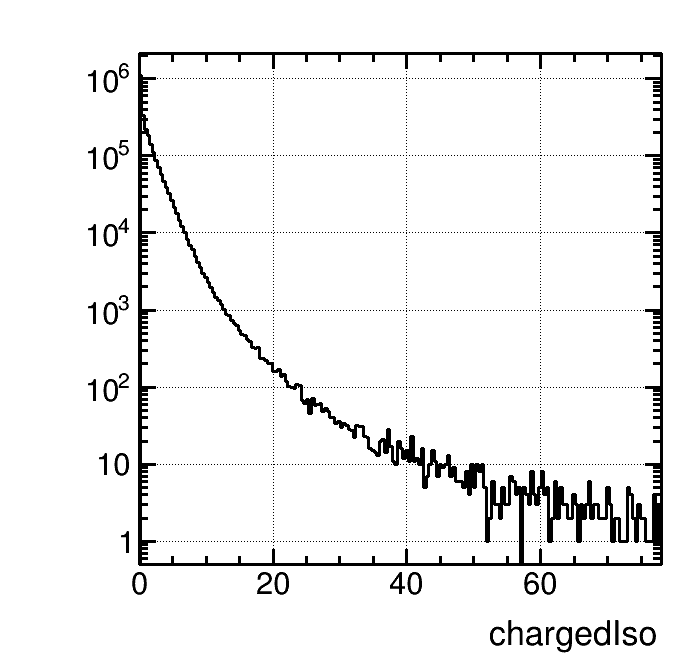

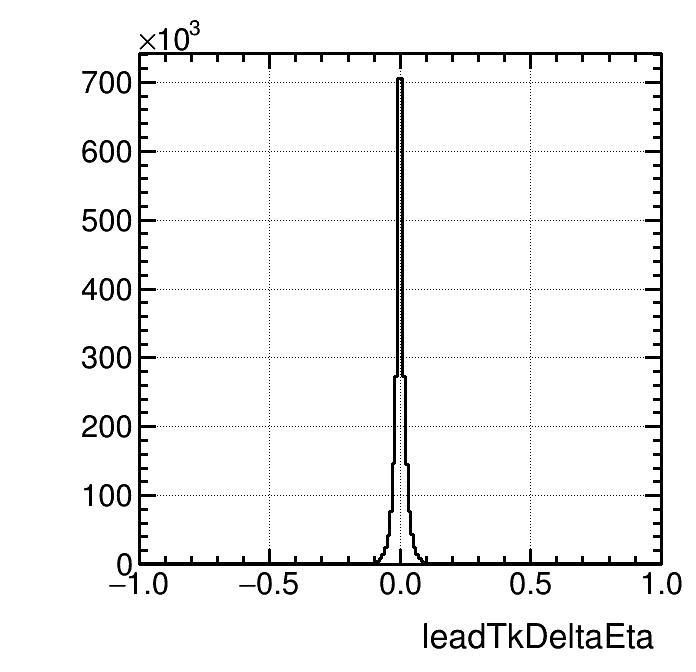

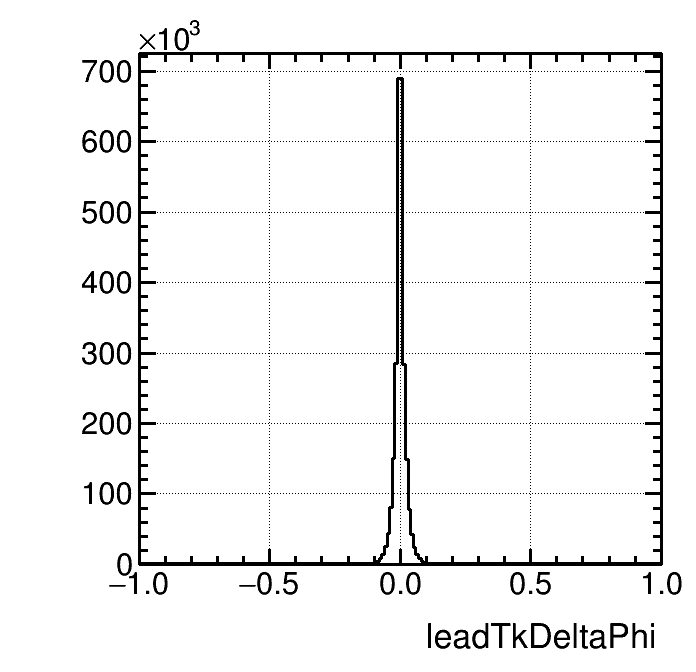

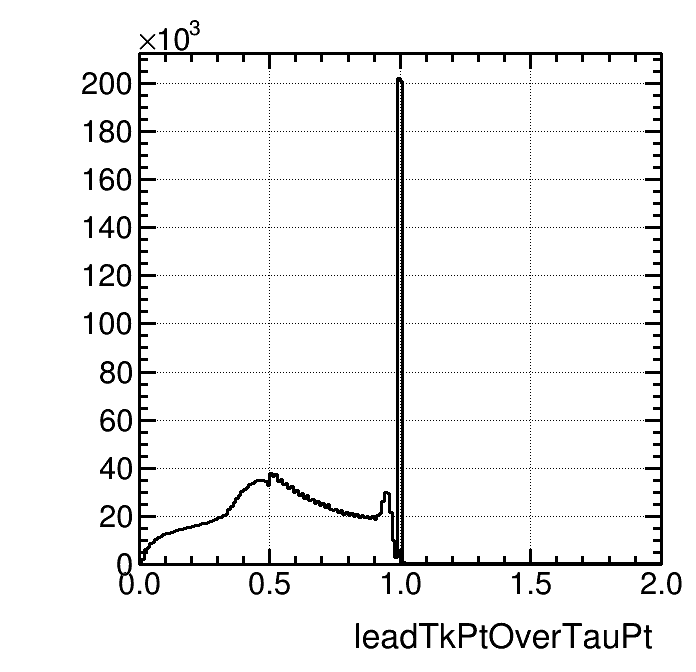

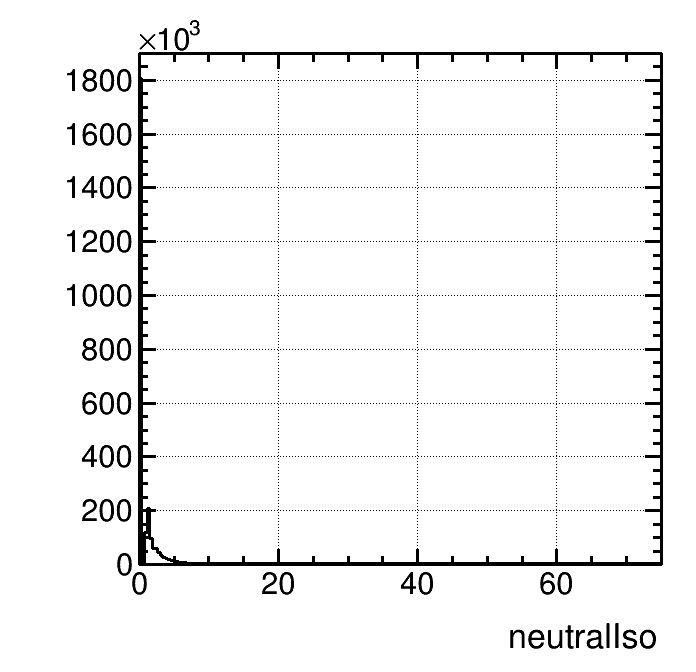

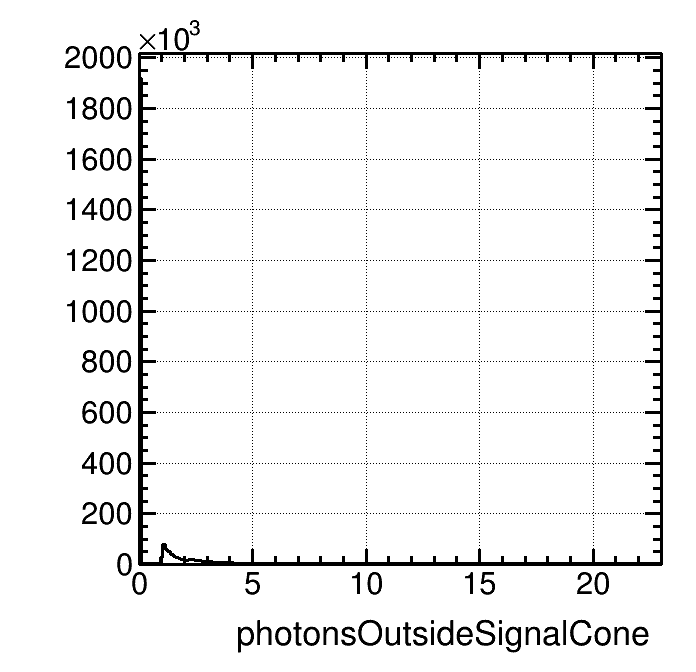

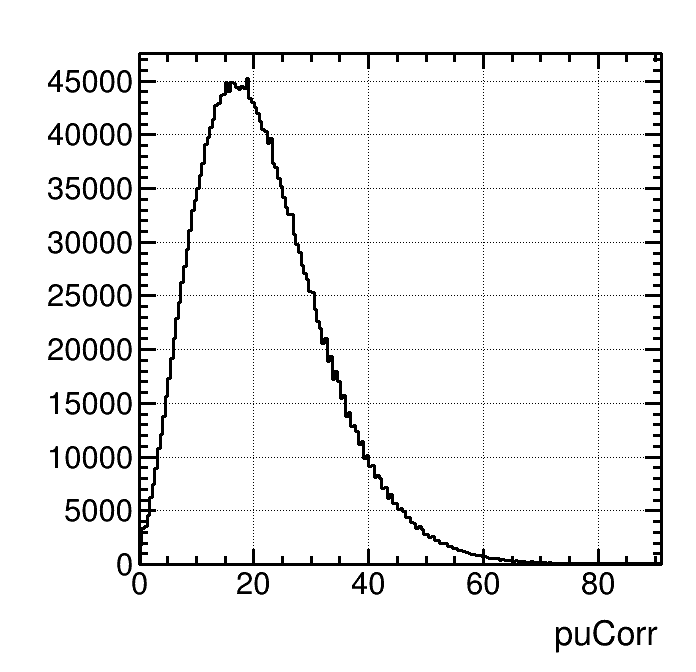

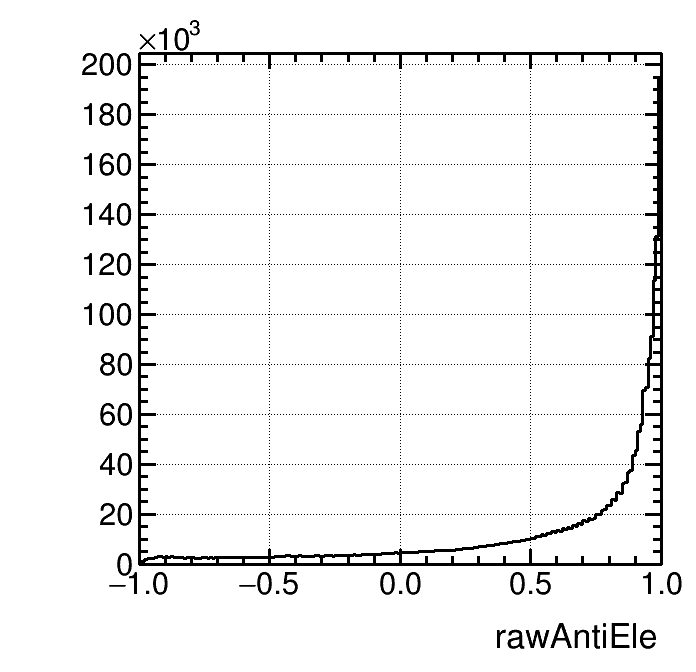

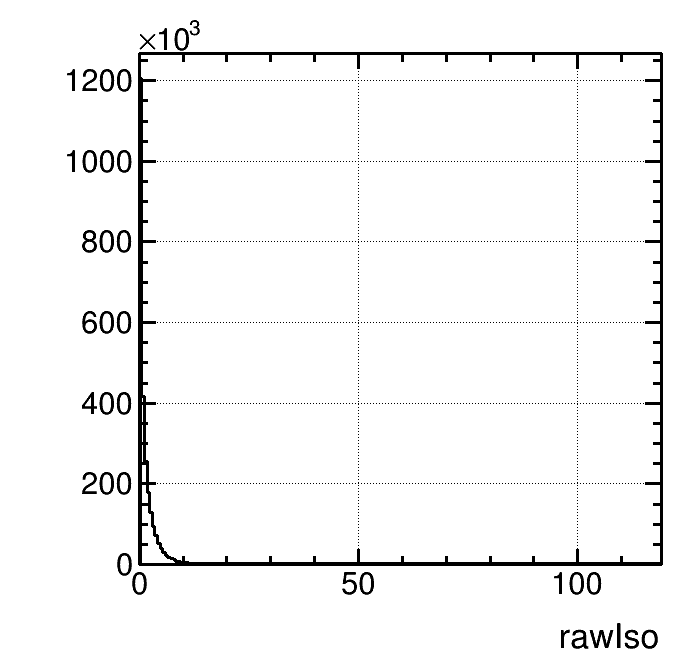

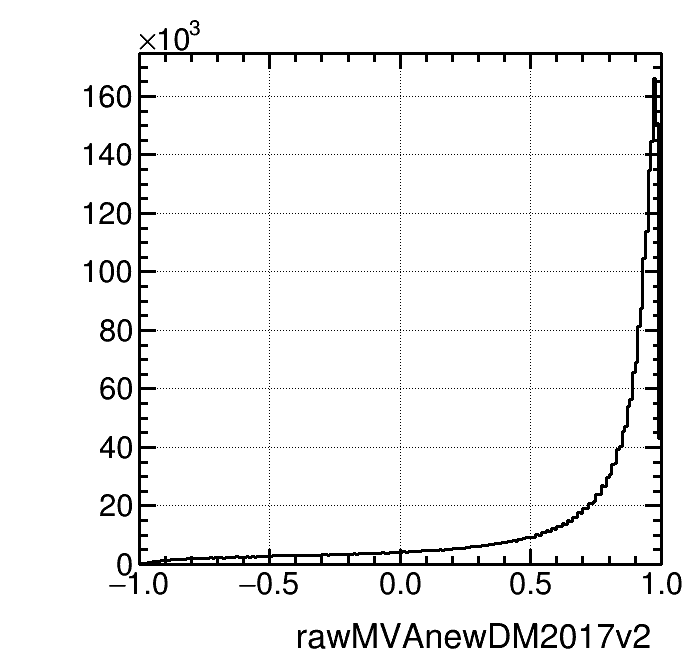

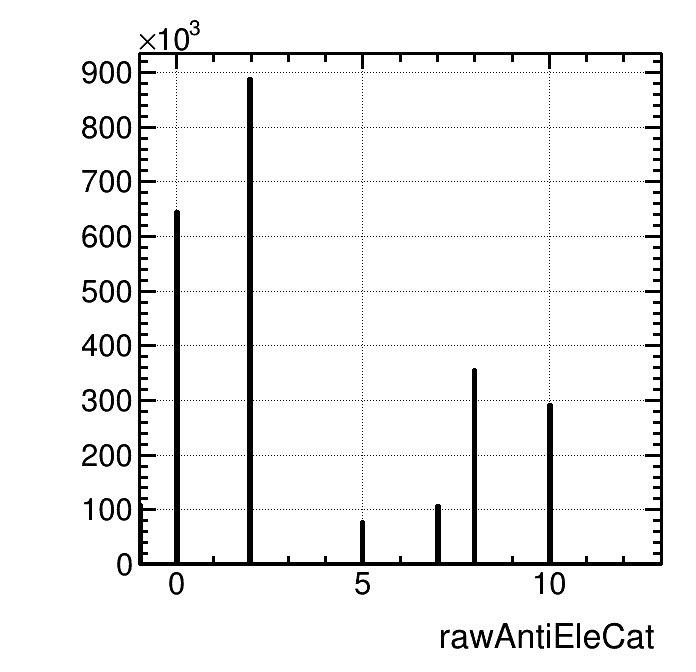

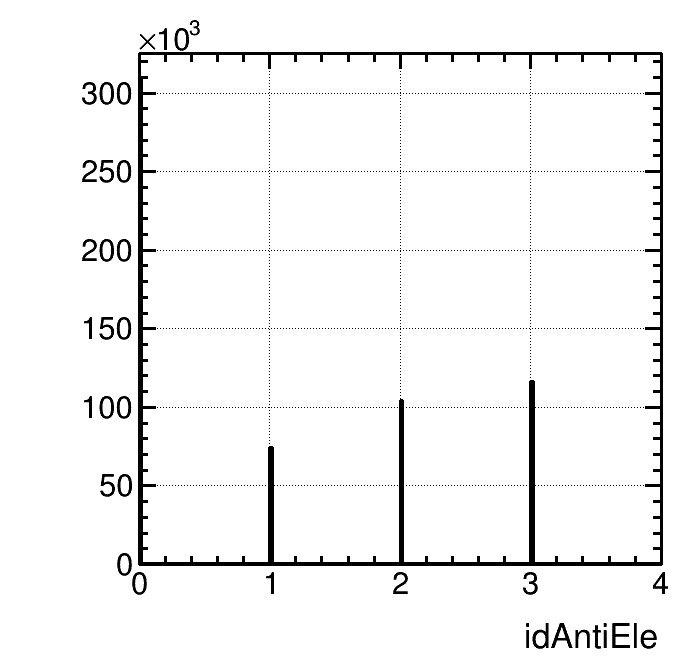

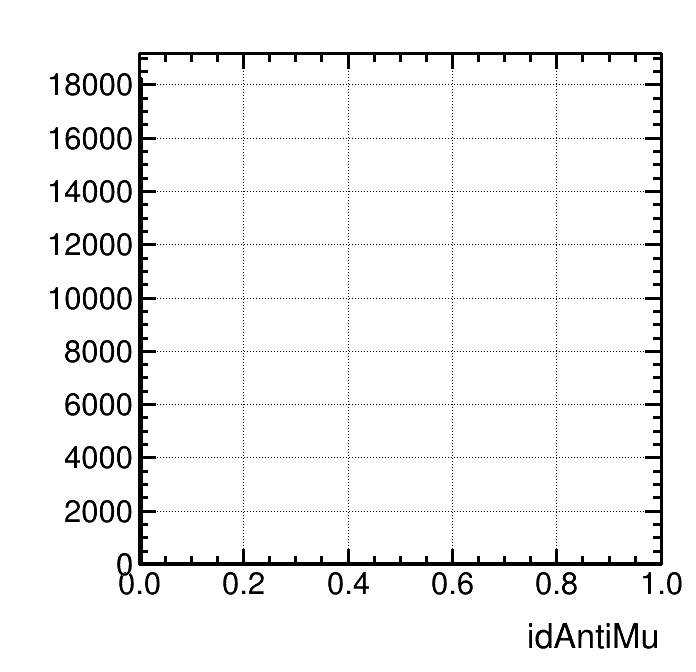

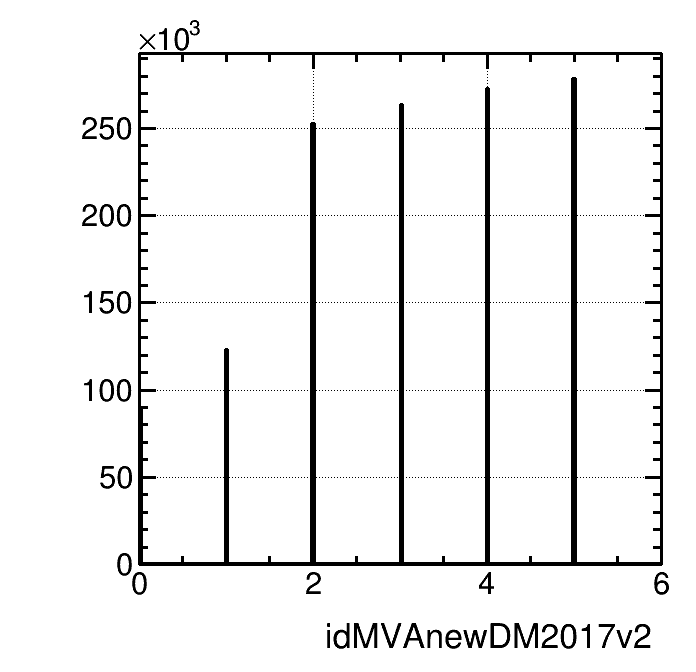

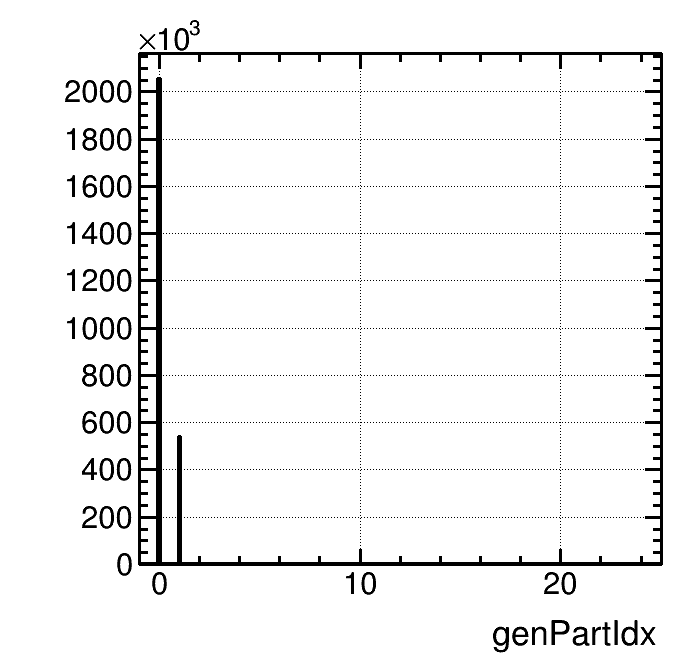

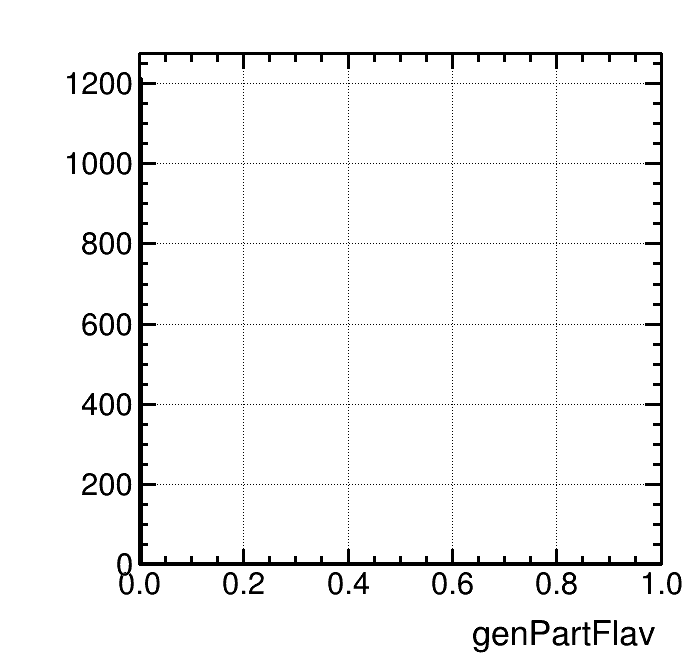

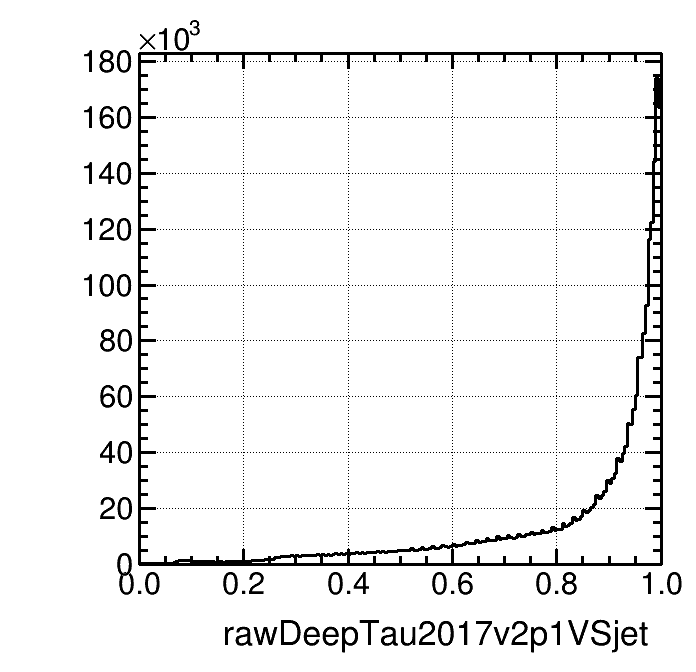

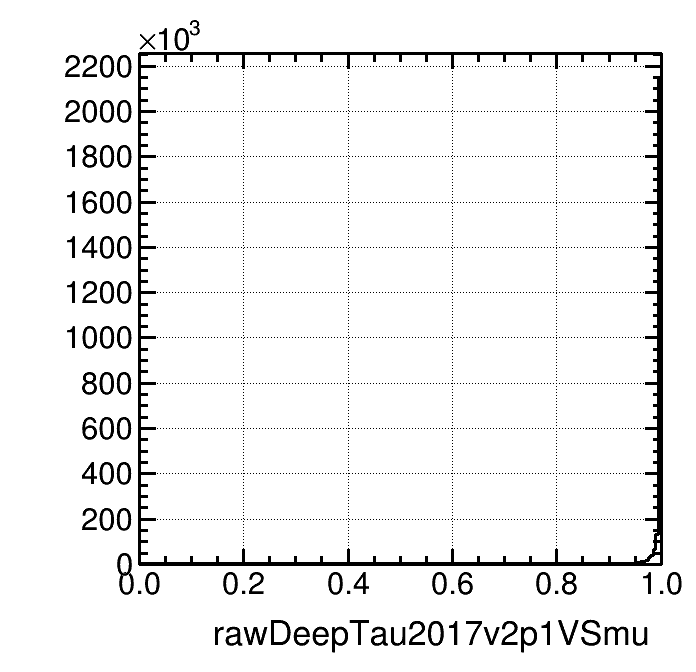

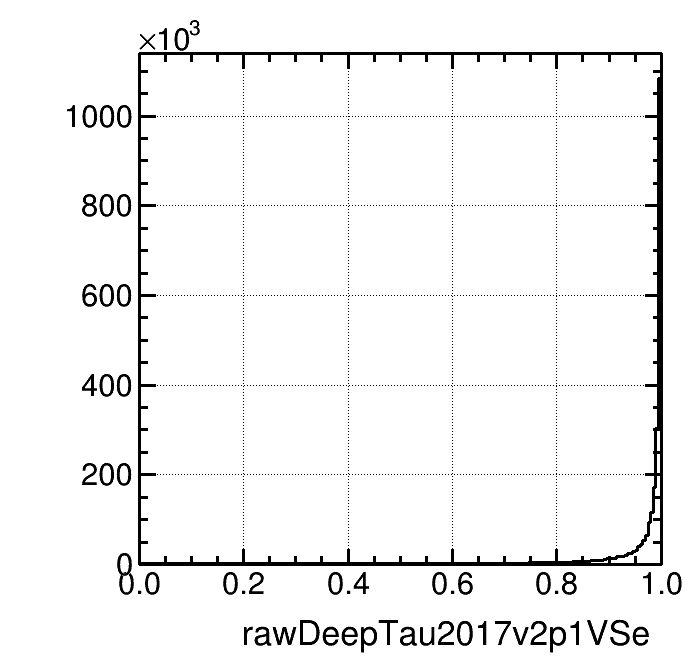

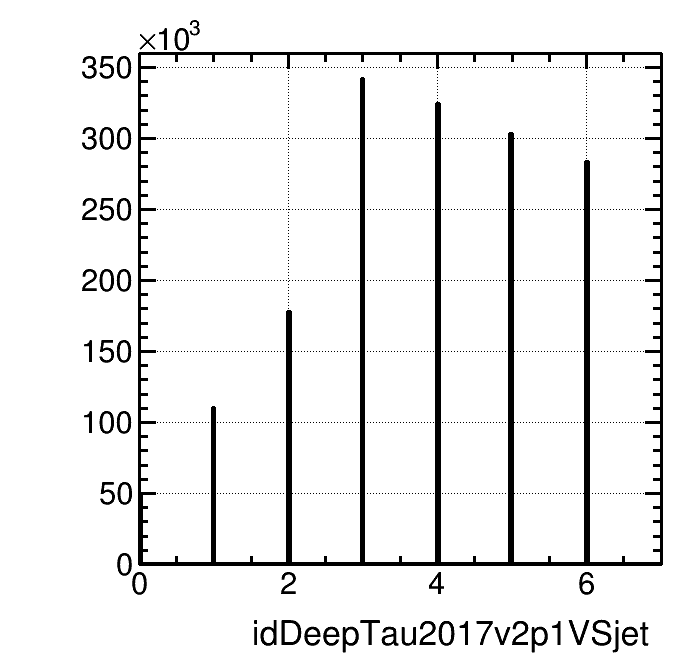

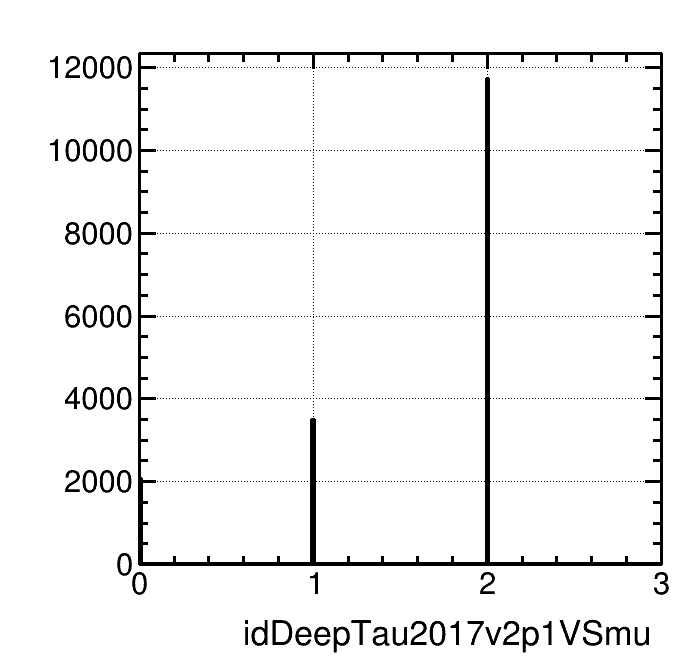

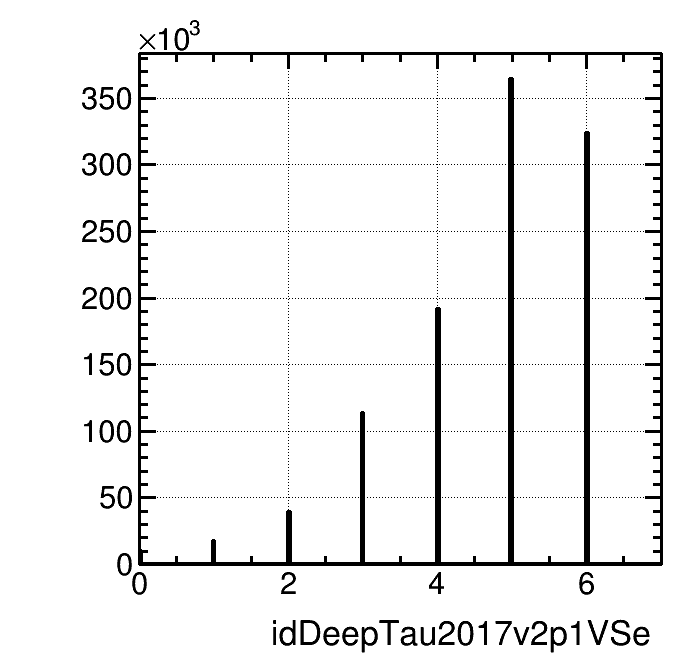

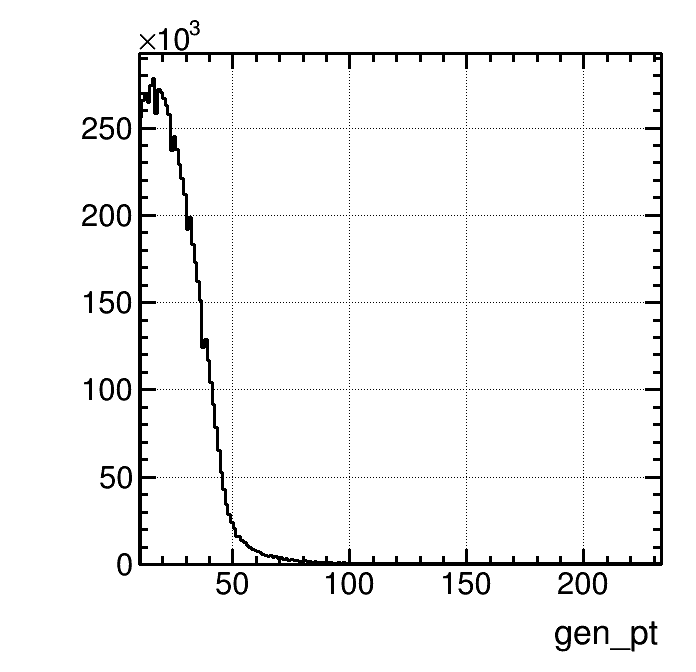

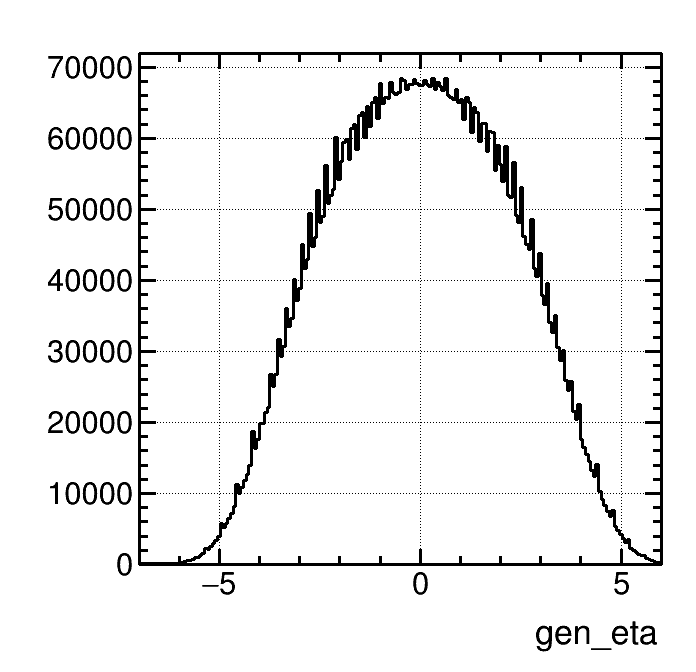

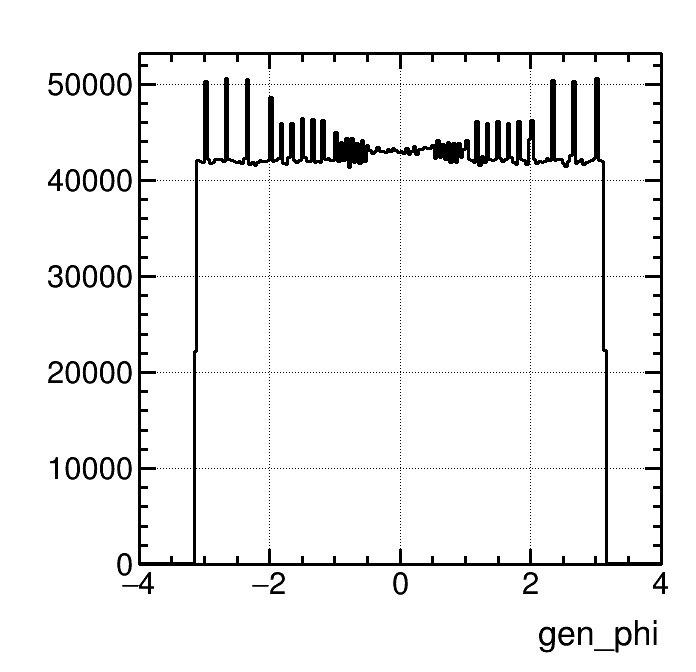

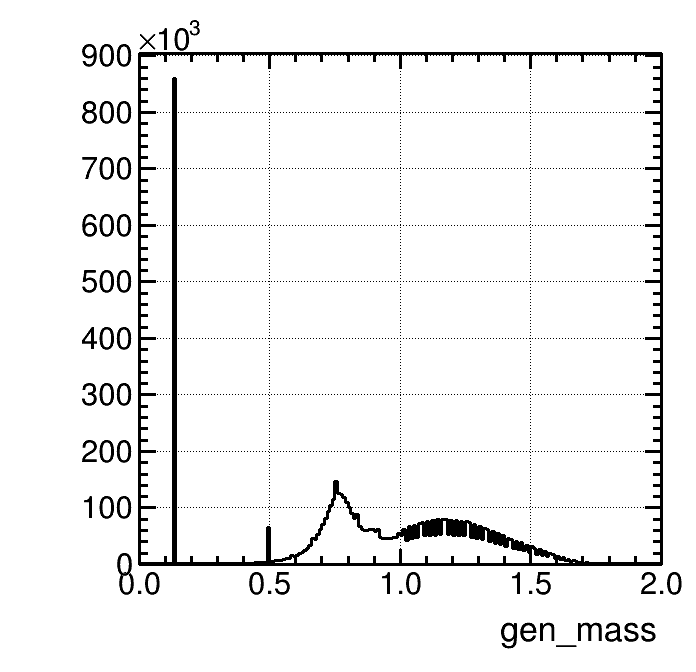

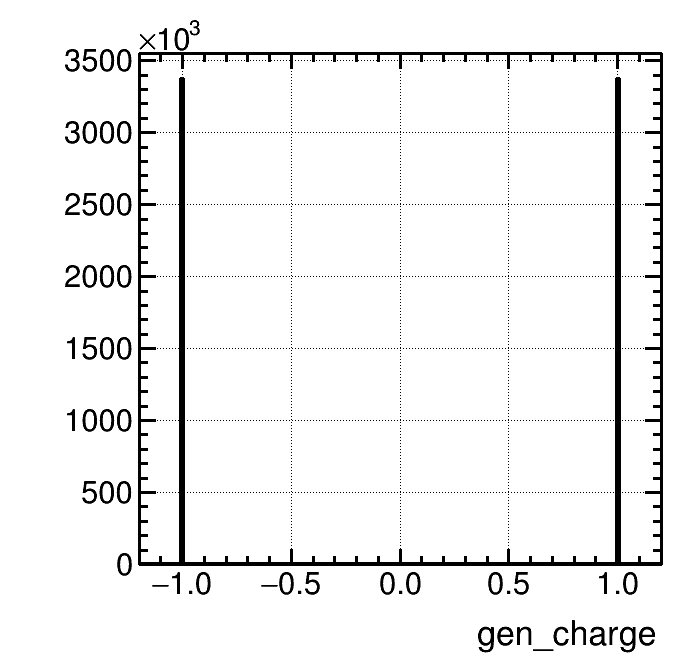

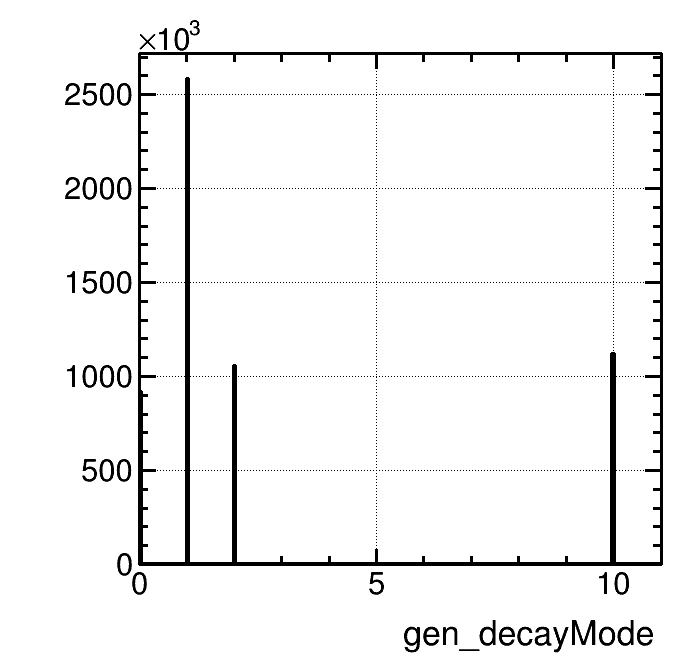

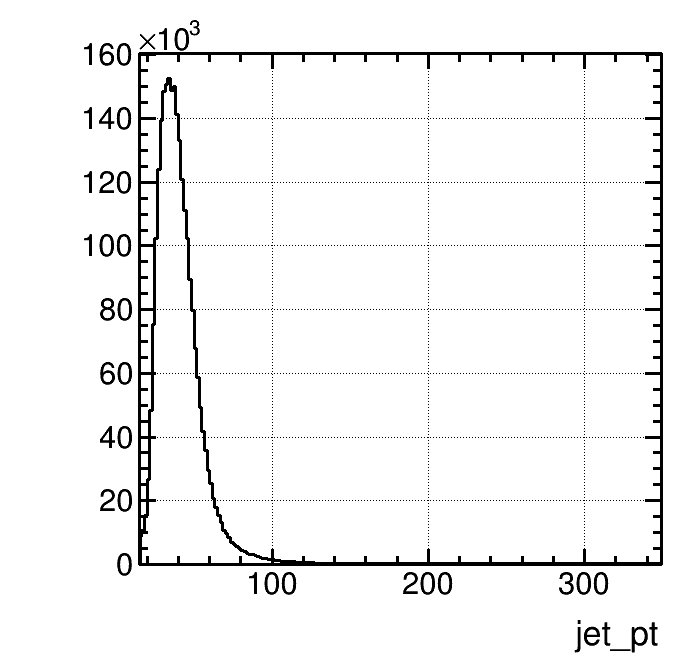

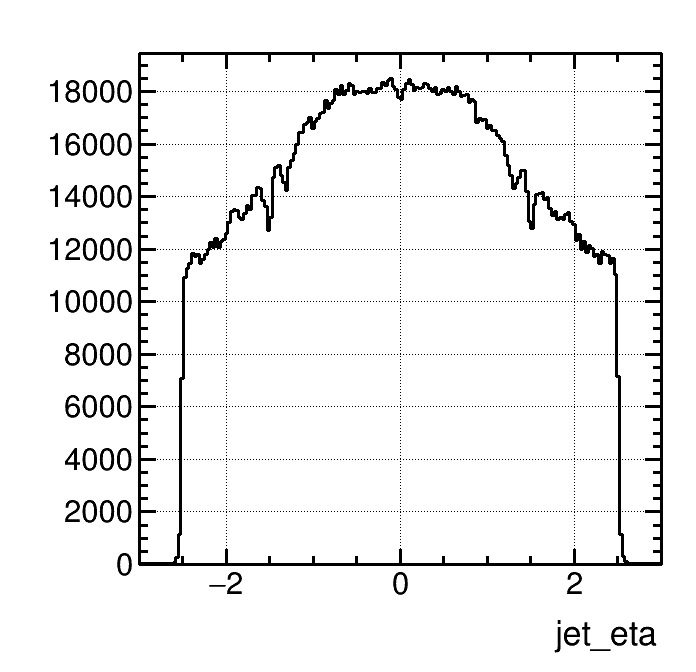

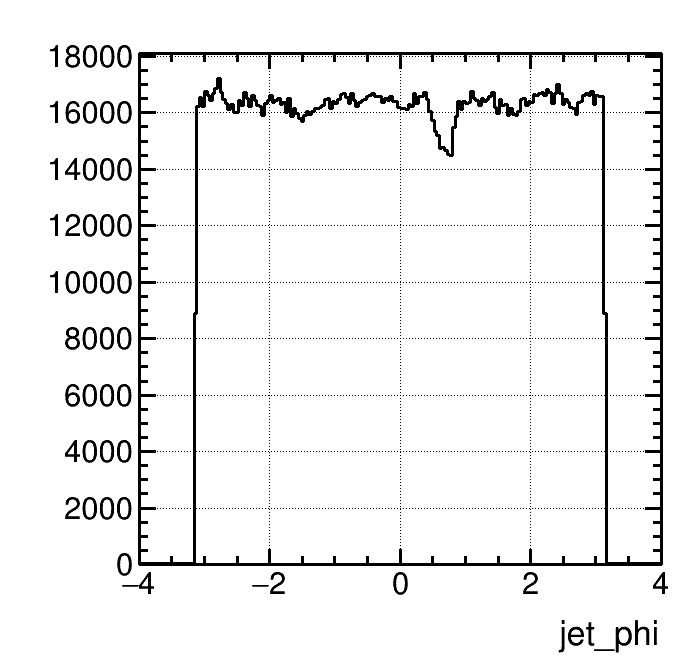

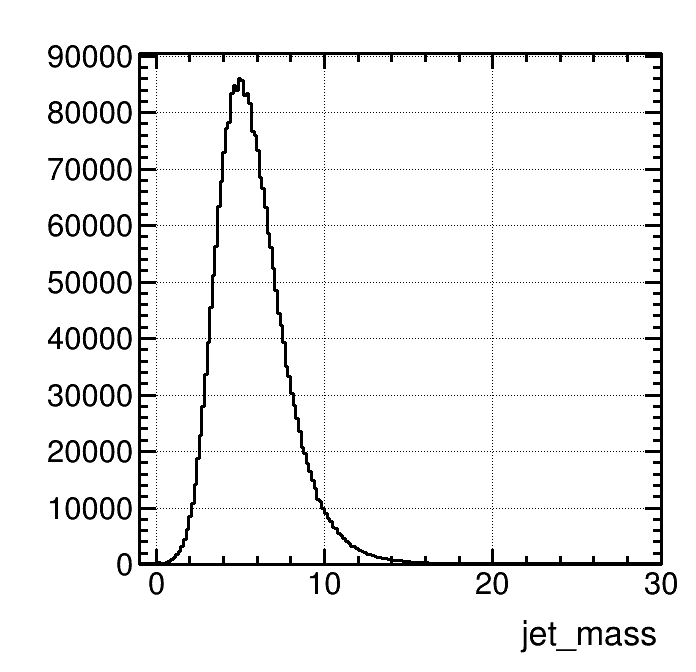

In [25]:
# Print all branch names
print([g.GetName() for g in tau_tree.GetListOfBranches()])

# # Manually draw distributions of variables obtained from the following list, like one would do with a TBrowser
# cv = ROOT.TCanvas()
# tau_tree.Draw('tau_pt')
# cv.Draw()
# tau_tree.Draw('tau_pt', 'tau_pt > 0. && tau_pt<100') # only draw if tau was actually reconstructed
# cv.Draw()

# Use some more magic to extract useful variable ranges towards automating drawing distributions of variables
import math
import numpy as np
cvs = []
hists = []
d_vars = ['tau_pt', 'tau_eta', 'tau_chargedIso', 'tau_decayMode', 'tau_mass']
# d_vars = [g.GetName() for g in tau_tree.GetListOfBranches()]
for i, var in enumerate(d_vars):
    print(var)
    cv = ROOT.TCanvas()
    cvs.append(cv)
    vals = tau_tree.AsMatrix(columns=[var]).flatten()
    vals = vals[vals>-10] # remove default values
    vals = vals[vals<np.percentile(vals, 99.99)] # remove outliers
    if not vals.any():
        continue
    hist = ROOT.TH1F(var, '', 200, math.floor(np.min(vals)), math.ceil(np.max(vals)))
    hists.append(hist)
    tau_tree.Project(var, var)
    hist.Draw()
    hist.GetXaxis().SetTitle(var[4:])
    cv.Draw()
    if var in ['tau_pt', 'tau_chargedIso']:
        cv.SetLogy(True)

# # Alternatively, to inspect the file, type t = ROOT.TBrowser() in an interactive ROOT 
# # session or "rootbrowse <filename>" in a shell

How do taus actually decay? Here's a table from the TAU-16-003 paper linked above that associates the different tau decay modes together with their branching fractions and whether the decay proceeds via an intermediate resonance:

![Tau decays](tau_decays.png)

Since decays of tau leptons to electrons or muons and neutrinos are experimentally very different with respect to decays to hadrons and a neutrino, they are covered by different physics object groups.
In the CMS tau reconstruction, we focus only on reconstructing hadronic tau decays.

The CMS tau reconstruction initially focussed on three main decay modes:
* One-prong (without pi0) - 1st line in the table above under hadronic decays (dm: 0)
* One-prong + pi0s - 2nd and 3rd lines (dm: 1, 2, 3, 4)
* Three-prong (without pi0) - 4th line (dm: 10)

In the tau reconstruction code, we give integer values to the decay modes via the relation `dm = 5*(n_charged - 1) + n_pi0`, as added in parentheses above.

To check whether a tau is reconstructed in any of these "old" decay modes, there is a flag `tau_decayModeFinding`.
Nowadays, we also look at an additional decay mode:
* Three-prong plus pi0 - 5th line (dm: 11)
Furthermore, we also try to reconstruct taus that have a 3-prong decay on generator level (dms 10, 11) but where one charged hadron is not reconstructed. These new reconstructed decay modes are sometimes called "2-prong modes":
* 3-prong with missing charged hadron and no pi0 (reco dm: 5)
* 3-prong with missing charged hadron and pi0 (reco dm: 6)

There is a flag `tau_decayModeFindingNewDMs` that checks if the tau was reconstructed in any of the decay modes. It is always true for reconstructed taus in the considered trees (and in MiniAOD), so we do not explicitly check it in the examples below.

*For simplicity, we do not separately look at old decay modes only (`tau_decayModeFinding`) below. It can be an interesting exercise to see how much the overall reconstruction efficiency decreases when considering only these old decay modes*


**Let's try to investigate if we efficiently reconstruct taus.**

In [ ]:
# We're interested in taus well within the tracker acceptance and with minimum pT
base_sel = 'tau_gen_pt>20. && abs(tau_gen_eta)<2.3'

n_all = tau_tree.Draw('1', base_sel)
n_pass = tau_tree.Draw('1', 'tau_pt>20 &&' + base_sel)
print(n_all, 'generated taus of which', n_pass, 'are reconstructed')
print(f'Efficiency: {n_pass/n_all:.3f}')
n_pass = tau_tree.Draw('1', 'tau_idDecayMode && tau_pt>20 &&' + base_sel)
print(n_pass, 'also pass the "old" decay mode finding')
print(f'Efficiency: {n_pass/n_all:.3f}')

How does the inclusive reconstruction efficiency come about?

The tau reconstruction proceeds as follows:
* First, the tau reconstruction is seeded by a jet (this step is very efficient)
* Second, charged hadron candidates are identified and pi0 candidates are reconstructed from photons (the latter need to fulfil some minimal criteria)
* Third, all possible tau candidates are built from the charged hadrons and pi0s, with the charged hadrons and pi0s required to be in a narrow cone around the reconstructed tau axis. The reconstructed taus are also checked for compatibility with the masses of intermediate resonances (rho(770 MeV) and a0(1260 MeV)).
* Fourth, the best tau candidate is retained. Of all taus that are reconstructed in one of the decay modes including cuts on the mass compatibility, the one with highest pT is retained.

***Which effects do you think limit the tau reconstruction efficiency?***

There are at least 3 relevant effects:
* The reconstruction efficiency for individual tau decay products, in particular for charged hadrons, is limited: In particular, the reconstruction efficiency for charged hadrons is 90% to good approximation and regardless of pT. *What does this imply for 1-prong and 3-prong taus?*
* For taus near the kinematic threshold, which we chose above to be 20 GeV, the reconstructed pT may be lower than the generated one.
* A wrong tau candidate may be selected as the best tau candidate, which can happen in particular if the mass compatibility criteria fail.

***To study the first, it's useful to check the efficiency per decay mode.***

In [ ]:
# Select 1-prong taus without pi0s, which has decay mode 0 according to the formula above
base_sel = 'tau_gen_pt>20. && abs(tau_gen_eta)<2.3 && tau_gen_decayMode==0'
n_all = tau_tree.Draw('1', base_sel)
n_pass = tau_tree.Draw('1', 'tau_pt>20 &&' + base_sel)
print(f'Efficiency: {n_pass/n_all:.3f}')

The efficiency is nearly 90% for 1-prong taus without pi0s, which is in line with our expectation that the reconstruction efficiency is merely limited by the charged hadron reconstruction efficiency.

***Can you print the inclusive reconstruction efficiencies for the other decay modes?***

*Hint: Use generated decay modes 1 and 2 for 1-prong + pi0s; decay mode 10 for 3-prong taus; and decay mode 11 for 3-prong taus without pi0s*

In [27]:
### It may be useful to start from the code above
for gen_dm in [0, 1, 2, 10, 11]:
    print(f'Investigating Tau DM {gen_dm}')
    base_sel = f'tau_gen_pt>20. && abs(tau_gen_eta)<2.3 && tau_gen_decayMode=={gen_dm}'
    n_all = tau_tree.Draw('1', base_sel)
    n_pass = tau_tree.Draw('1', 'tau_pt>20 &&' + base_sel)
    print(f'Efficiency: {n_pass/n_all:.3f}')

Investigating Tau DM 0
Efficiency: 0.874
Investigating Tau DM 1
Efficiency: 0.715
Investigating Tau DM 2
Efficiency: 0.639
Investigating Tau DM 10
Efficiency: 0.843
Investigating Tau DM 11
Efficiency: 0.743


Besides reconstructing the tau at all, it may also be interesting to understand whether the tau is actually reconstructed in its corresponding decay mode. ***Can you check how often taus are reconstructed in the correct decay mode?***

In [33]:
# Your code goes here
# Hint: use an expression like 'tau_decayMode == 0' when you calculate the number of passing events
for gen_dm in [0, 1, 2, 10, 11]:
    print(f'Investigating Tau DM {gen_dm}')
    base_sel = f'tau_gen_pt>20. && abs(tau_gen_eta)<2.3 && tau_gen_decayMode=={gen_dm}'
    n_all = tau_tree.Draw('1', base_sel)
    n_pass = tau_tree.Draw('1', f'tau_pt>20 && tau_decayMode=={gen_dm} &&' + base_sel)
    print(f'Efficiency: {n_pass/n_all:.3f}')

Investigating Tau DM 0
Efficiency: 0.794
Investigating Tau DM 1
Efficiency: 0.523
Investigating Tau DM 2
Efficiency: 0.000
Investigating Tau DM 10
Efficiency: 0.592
Investigating Tau DM 11
Efficiency: 0.334


Not only the reconstruction efficiency for single particles limits the tau efficiency, but also the pT resolution of the reconstructed particles and the criteria we impose on the mass. Let's investigate how they look!

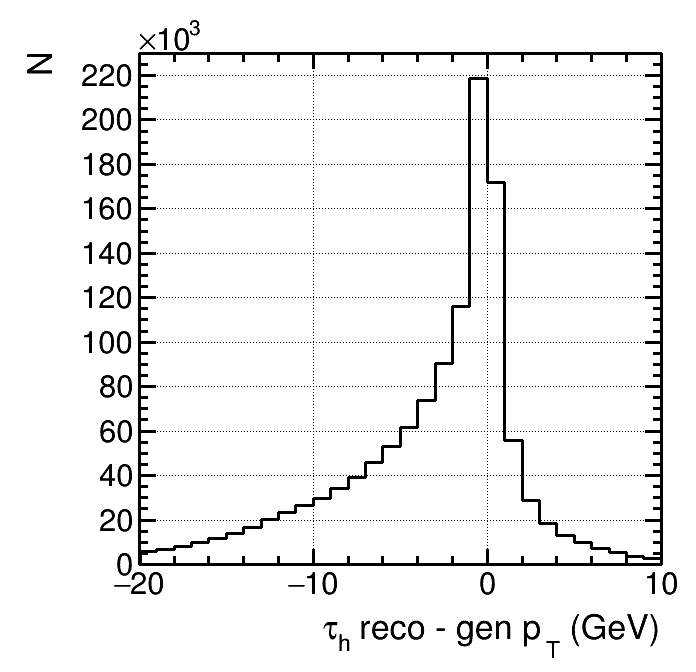

In [34]:
# We use a minimum generated pT of 30. so we do not run into threshold effects 
# given we only have reconstructed taus with pT > 18 GeV in the trees
base_sel = 'tau_gen_pt>30. && abs(tau_gen_eta)<2.3'
h_res = ROOT.TH1F('h_res', '', 30, -20., 10.)
h_res.GetXaxis().SetTitle("#tau_{h} reco - gen p_{T} (GeV)")
h_res.GetYaxis().SetTitle("N")
tau_tree.Project('h_res', 'tau_pt - tau_gen_pt', base_sel)
canvas = ROOT.TCanvas()
h_res.Draw()
canvas.Draw()

There is a nice peak at 0, as one would expect, but also a tail towards lower reconstructed values.

***Can you find out if this tail comes from particular generated decay modes?***

Warning in <TFile::Append>: Replacing existing TH1: h_res (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_res (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_res (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_res (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_res (Potential memory leak).


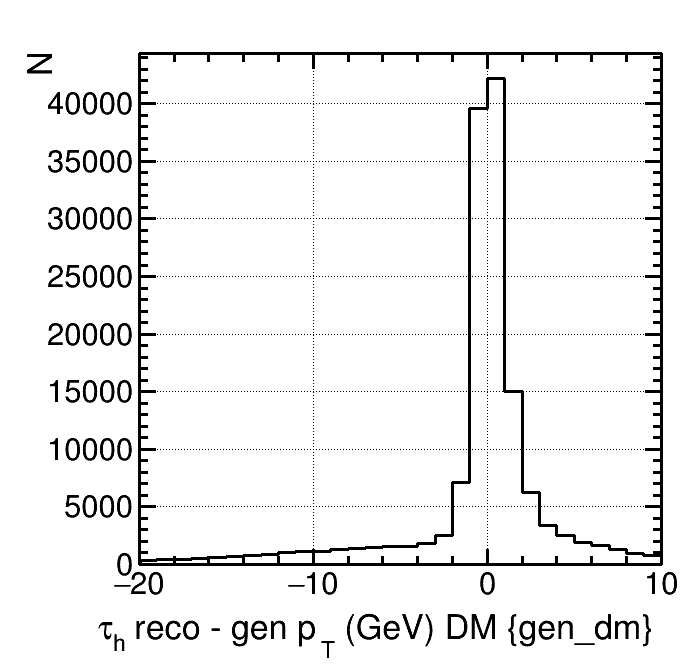

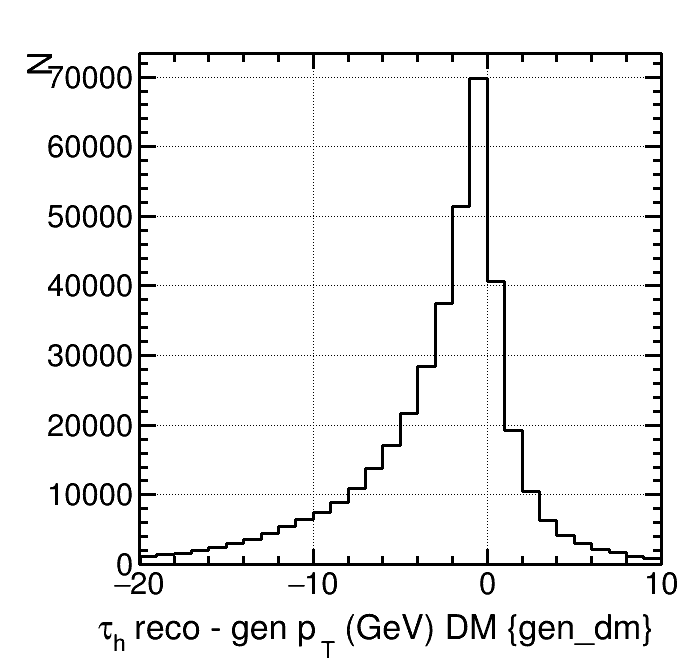

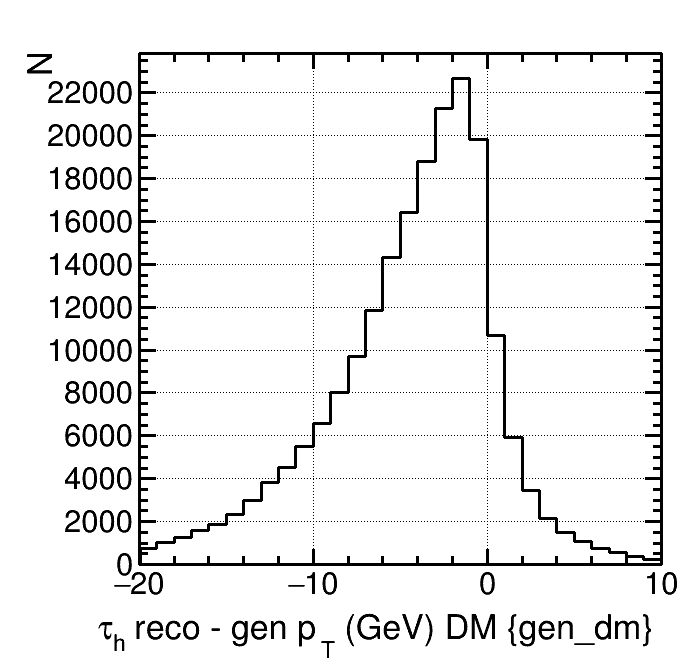

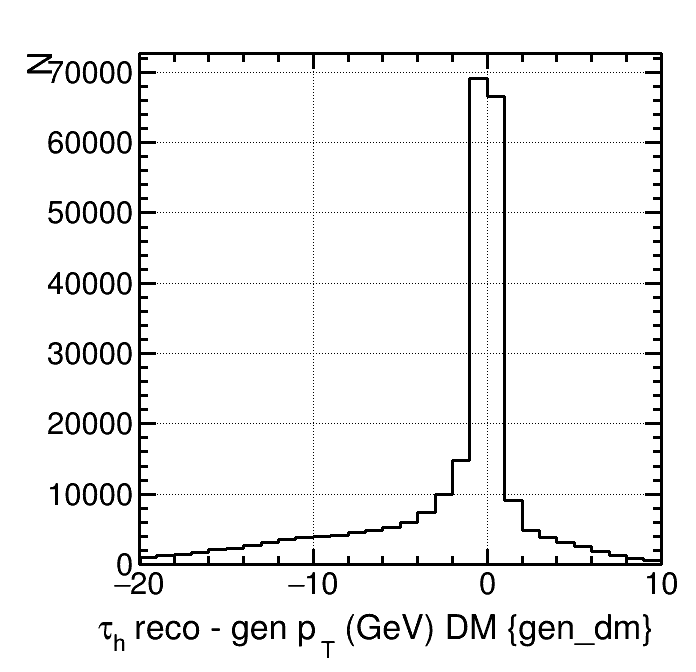

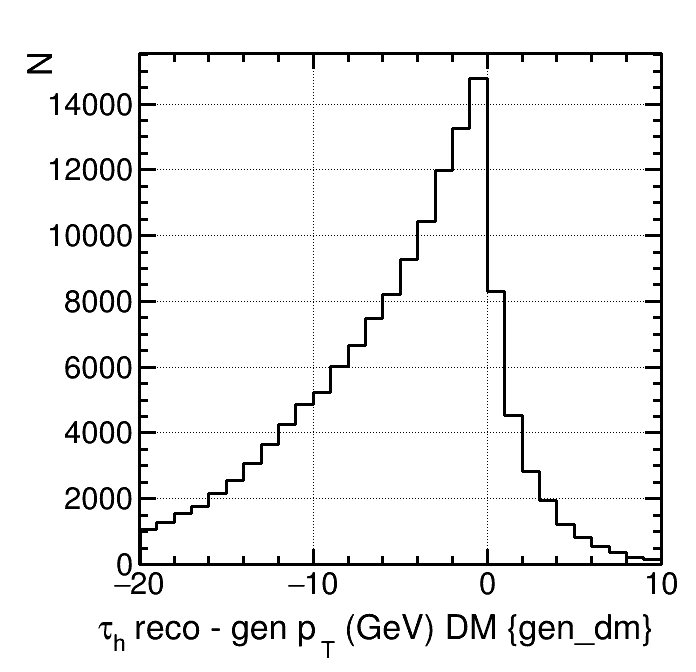

In [38]:
# Your code goes here.
# Hint: Select a specific generated decay mode in the base_sel string.
# It can also be interesting to see if these tails arise if taus are reconstructed in a wrong decay mode.
keeper = []
for gen_dm in [0, 1, 2, 10, 11]:
    base_sel = f'tau_gen_pt>30. && abs(tau_gen_eta)<2.3 && tau_gen_decayMode == {gen_dm}'
    h_res = ROOT.TH1F('h_res', '', 30, -20., 10.)
    h_res.GetXaxis().SetTitle("#tau_{h} reco - gen p_{T} (GeV) DM {gen_dm}")
    h_res.GetYaxis().SetTitle("N")
    tau_tree.Project('h_res', 'tau_pt - tau_gen_pt', base_sel)
    canvas = ROOT.TCanvas()
    keeper.append(canvas)
    keeper.append(h_res)
    h_res.Draw()
    canvas.Draw()

To draw a nice plot of the decay mode migration matrix, we can use a short script that makes decay mode migration plots from a passed TTree. This plot gives very useful diagnostic information about the tau reconstruction since it gives the fractions of taus that are reconstructed in the right decay mode, in any decay mode, and of those that are not reconstructed at all.

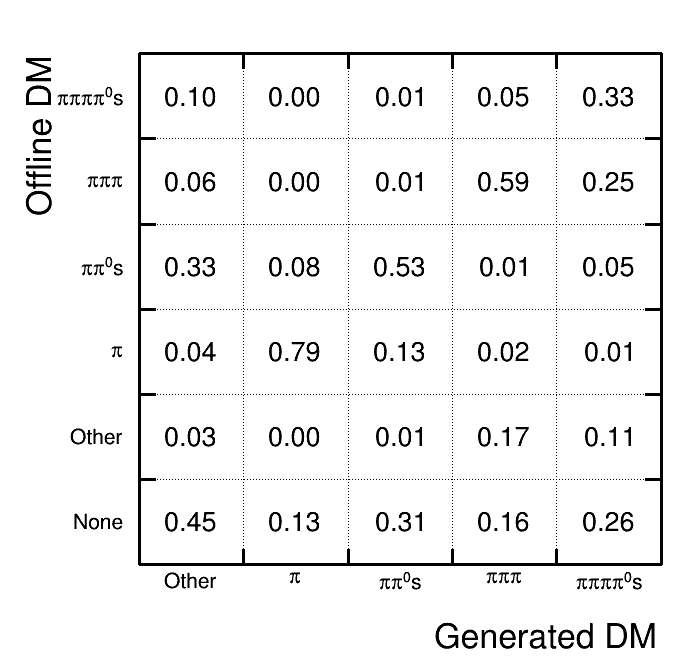

In [39]:
canvas = dm_migration(tau_tree)
canvas.Draw()

The function takes as one possible argument a generator cut, which is by default set to
`gen_cut='tau_genpt>20 && abs(tau_geneta)<2.3'`

***Does the decay mode matrix change for higher tau pT?***

Warning in <TCanvas::Constructor>: Deleting canvas with same name: decay_mode_matrix
Warning in <TFile::Append>: Replacing existing TH1: migration (Potential memory leak).


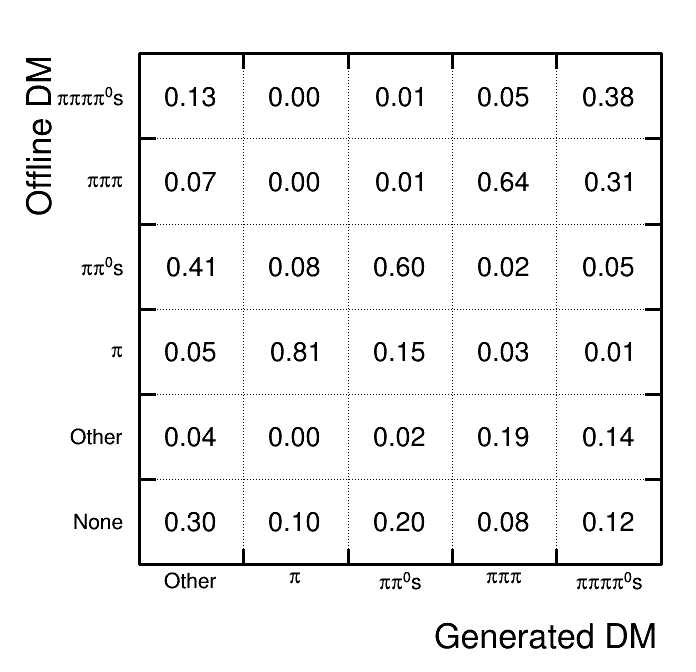

In [45]:
# Your code to make the plot with different generator cuts goes here
canvas = dm_migration(tau_tree, gen_cut='tau_gen_pt>30 && abs(tau_gen_eta)<2.3')
canvas.Draw()

***Advanced exercise:***

Investigate the dm_migration script: It takes as additional arguments a string that converts the decay mode information to integers and a list of labels. Can you divide the 1-prong + pi0s decay modes into ones with a single pi0 and ones with more than 1 pi0? Is our reconstruction able to disentangle taus with different numbers of pi0s?

Warning in <TCanvas::Constructor>: Deleting canvas with same name: decay_mode_matrix
Warning in <TFile::Append>: Replacing existing TH1: migration (Potential memory leak).


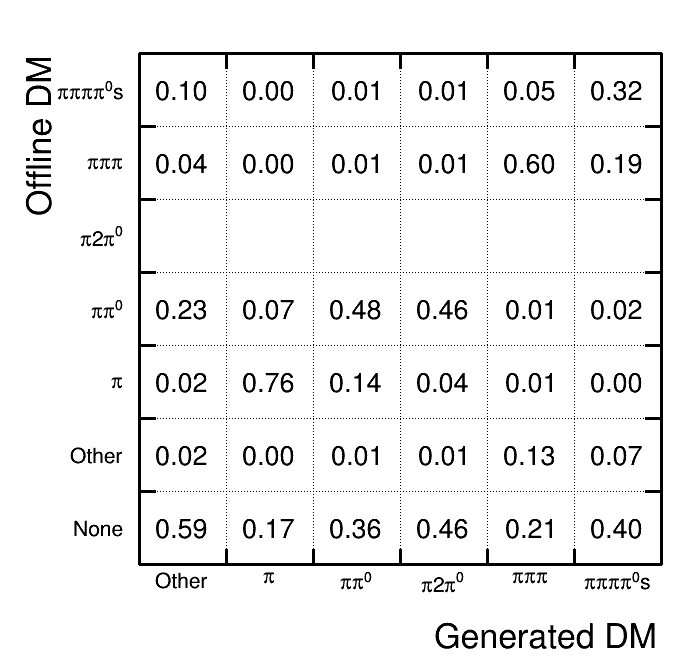

In [46]:
tau_decayMode_string = ('-2'
                         '+ (tau_pt>30 && tau_decayMode>=0 && tau_decayMode <200)*(1 ' # will contain reco DM 5 and 6 and other gen DMs
                            '+ (tau_decayMode==0)'
                            '+ 2*(tau_decayMode==1)'
                            '+ 3*(tau_decayMode==2)'
                            '+ 4*(tau_decayMode==10)'
                            '+ 5*(tau_decayMode==11))'
            )
labels = ['None', 'Other', '#pi', '#pi#pi^{0}', '#pi2#pi^{0}', '#pi#pi#pi', '#pi#pi#pi#pi^{0}s']
canvas = dm_migration(tau_tree, tau_decayMode_string=tau_decayMode_string, labels=labels)
canvas.Draw()